In [1]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import time

import torch
import scipy.sparse
from torch import Tensor
from torch.utils.dlpack import to_dlpack, from_dlpack

import torch_geometric.data
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.utils import k_hop_subgraph, from_scipy_sparse_matrix, to_scipy_sparse_matrix
from torch_geometric.utils import is_undirected, to_undirected
from scipy.sparse import csr_matrix

from pgmpy.estimators.CITests import chi_square
from scipy.special import softmax

from sklearn.model_selection import train_test_split

import torch.nn.functional as F
from torch.nn import BatchNorm1d
from torch_geometric.nn import GCNConv




Bad key text.latex.unicode in file /Users/kenzaamara/opt/anaconda3/envs/Explain/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key text.latex.preview in file /Users/kenzaamara/opt/anaconda3/envs/Explain/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 125 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/kenzaamara/opt/anaconda3/envs/Explain/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 157 ('mathtext.

In [2]:
def ba(n, m, role_start=0):
    G = nx.barabasi_albert_graph(n, m)
    labels = [role_start for i in range(n)]
    return G, labels


def house(start, role_start=1):
    """Builds a house-like  graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    role_start  :    starting index for the roles
    OUTPUT:
    -------------
    graph       :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    """
    graph = nx.Graph()
    graph.add_nodes_from(range(start, start + 5))
    graph.add_edges_from(
        [
            (start, start + 1),
            (start + 1, start + 2),
            (start + 2, start + 3),
            (start + 3, start),
        ]
    )
    graph.add_edges_from([(start + 4, start), (start + 4, start + 1)])
    roles = [role_start, role_start, role_start + 1, role_start + 1, role_start + 2]
    return graph, roles


def build_ba_shapes(n_basis=300, n_shapes=80, rdm_basis_plugins=True, rdm_shape_plugins=True, pos=3, add_random_edges=0, m=5):
    # where you will plugin the houses
    # Sample (with replacement) where to attach the new motifs
    if rdm_basis_plugins is True:
        plugins = np.random.choice(n_basis, n_shapes, replace=False)
    else:
        spacing = math.floor(n_basis / n_shapes)
        plugins = [int(k * spacing) for k in range(n_shapes)]

    basis, role_id = ba(n_basis, m)
    start = n_basis
    for shape_id in range(n_shapes):
        graph_s, role_graph_s = house(start)
        n_s = nx.number_of_nodes(graph_s)
        basis.add_nodes_from(graph_s.nodes())
        basis.add_edges_from(graph_s.edges())
        if rdm_shape_plugins is True:
            pos = np.random.choice(range(start, start+n_s))
        basis.add_edges_from([(pos, plugins[shape_id])])
        role_id += role_graph_s
        start += n_s

    if add_random_edges > 0:
        # add random edges between nodes:
        n_rand = int(n_basis*add_random_edges)
        for p in range(n_rand):
            src, dest = np.random.choice(nx.number_of_nodes(basis), 2, replace=False)
            basis.add_edges_from([(src, dest)])
            
            
    # Add constant node features
    feat_dict = {i:{'feat': np.array([1], dtype=np.float32)} for i in basis.nodes()}
    nx.set_node_attributes(basis, feat_dict)
    
    # Convert graph into undirected graph
    basis = basis.to_undirected()

    return basis, role_id, plugins


In [141]:
def from_edge_index_to_adj(edge_index, max_n):
    adj = to_scipy_sparse_matrix(edge_index).toarray()
    assert len(adj)<=max_n, "The adjacency matrix contains more nodes than the graph!"
    if len(adj)<max_n :
        adj = np.pad(adj, (0, max_n-len(adj)), mode='constant')
    return torch.FloatTensor(adj)

def from_adj_to_edge_index(adj):
    A = csr_matrix(adj)
    edges, _ = from_scipy_sparse_matrix(A)
    return torch.LongTensor(edges)

In [4]:
def build_data(n_basis=300, n_shapes=80):
    G, labels, plugins = build_ba_shapes(n_basis, n_shapes)
    
    data = from_networkx(G.to_undirected(), all)
    data.adj = torch.LongTensor(nx.to_numpy_matrix(G))
    data.num_classes = len(np.unique(labels))
    data.y = torch.LongTensor(labels)
    n = data.num_nodes
    data.train_mask, data.val_mask, data.test_mask = torch.zeros(n, dtype=torch.uint8), \
                                                    torch.zeros(n, dtype=torch.uint8), \
                                                    torch.zeros(n, dtype=torch.uint8)
    train_ids, test_ids = train_test_split(range(n), test_size=0.2, random_state=42, shuffle=True)
    train_ids, val_ids = train_test_split(train_ids, test_size=0.15, random_state=42, shuffle=True)

    data.train_mask[train_ids] = 1
    data.val_mask[val_ids] = 1
    data.test_mask[test_ids] = 1
    
    return data

In [5]:
def preprocess_input_graph(G, labels, normalize_adj=False):
    """ Load an existing graph to be converted for the experiments.
    Args:
        G: Networkx graph to be loaded.
        labels: Associated node labels.
        normalize_adj: Should the method return a normalized adjacency matrix.
    Returns:
        A dictionary containing adjacency, node features and labels
    """
    adj = np.array(nx.to_numpy_matrix(G))
    if normalize_adj:
        sqrt_deg = np.diag(1.0 / np.sqrt(np.sum(adj, axis=0, dtype=float).squeeze()))
        adj = np.matmul(np.matmul(sqrt_deg, adj), sqrt_deg)

    existing_node = list(G.nodes)[-1]
    feat_dim = G.nodes[existing_node]["feat"].shape[0]
    f = np.zeros((G.number_of_nodes(), feat_dim), dtype=float)
    for i, u in enumerate(G.nodes()):
        f[i, :] = G.nodes[u]["feat"]

    # add batch dim
    adj = np.expand_dims(adj, axis=0)
    f = np.expand_dims(f, axis=0)
    labels = np.expand_dims(labels, axis=0)
    return {"adj": adj, "feat": f, "labels": labels}

In [9]:
def prepare_data(n_basis = 300, n_shapes = 80):
    G, labels, plugins = build_ba_shapes(n_basis, n_shapes)
    
    
    data = from_networkx(G.to_undirected(), all)
    data.adj = torch.LongTensor(nx.to_numpy_matrix(G))
    data.num_classes = len(np.unique(labels))
    data.y = torch.LongTensor(labels)
    
    
    dict_data = preprocess_input_graph(G, labels, normalize_adj=False)
    labels = torch.tensor(dict_data["labels"], dtype=torch.long)
    adj = torch.tensor(dict_data["adj"], dtype=torch.float)
    x = torch.tensor(dict_data["feat"], requires_grad=True, dtype=torch.float)
    edge_index = []
    for A in adj:
        edge_index.append(from_adj_to_edge_index(A))
    edge_index = torch.stack(edge_index)
    
    return data, dict_data, x, adj, edge_index, labels

In [181]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F



# GCN basic operation
class GraphConv(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        add_self=False,
        normalize_embedding=False,
        dropout=0.0,
        bias=True,
        gpu=True,
        att=False,
    ):
        super(GraphConv, self).__init__()
        self.att = att
        self.add_self = add_self
        self.dropout = dropout
        if dropout > 0.001:
            self.dropout_layer = nn.Dropout(p=dropout)
        self.normalize_embedding = normalize_embedding
        self.input_dim = input_dim
        self.output_dim = output_dim
        if not gpu:
            self.weight = nn.Parameter(torch.FloatTensor(input_dim, output_dim))
            if add_self:
                self.self_weight = nn.Parameter(
                    torch.FloatTensor(input_dim, output_dim)
                )
            if att:
                self.att_weight = nn.Parameter(torch.FloatTensor(input_dim, input_dim))
        else:
            self.weight = nn.Parameter(torch.FloatTensor(input_dim, output_dim).cuda())
            if add_self:
                self.self_weight = nn.Parameter(
                    torch.FloatTensor(input_dim, output_dim).cuda()
                )
            if att:
                self.att_weight = nn.Parameter(
                    torch.FloatTensor(input_dim, input_dim).cuda()
                )
        if bias:
            if not gpu:
                self.bias = nn.Parameter(torch.FloatTensor(output_dim))
            else:
                self.bias = nn.Parameter(torch.FloatTensor(output_dim).cuda())
        else:
            self.bias = None

        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, adj):
        if self.dropout > 0.001:
            x = self.dropout_layer(x)
        # deg = torch.sum(adj, -1, keepdim=True)
        if self.att:
            x_att = torch.matmul(x, self.att_weight)
            # import pdb
            # pdb.set_trace()
            att = x_att @ x_att.permute(0, 2, 1)
            # att = self.softmax(att)
            adj = adj * att

        y = torch.matmul(adj, x)
        y = torch.matmul(y, self.weight)
        if self.add_self:
            self_emb = torch.matmul(x, self.self_weight)
            y += self_emb
        if self.bias is not None:
            y = y + self.bias
        #if self.normalize_embedding:
            #y = F.normalize(y, p=2, dim=2)
            # print(y[0][0])
        return y, adj


class GcnEncoderGraph(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        embedding_dim,
        label_dim,
        num_layers,
        pred_hidden_dims=[],
        concat=True,
        bn=True,
        dropout=0.0,
        add_self=False,
        args=None,
    ):
        super(GcnEncoderGraph, self).__init__()
        self.concat = concat
        add_self = add_self
        self.bn = bn
        self.num_layers = num_layers
        self.num_aggs = 1

        self.bias = True
        self.gpu = args['gpu']
        if args['method'] == "att":
            self.att = True
        else:
            self.att = False
        #if args is not None:
            #self.bias = args.bias

        self.conv_first, self.conv_block, self.conv_last = self.build_conv_layers(
            input_dim,
            hidden_dim,
            embedding_dim,
            num_layers,
            add_self,
            normalize=True,
            dropout=dropout,
        )
        self.act = nn.ReLU()
        self.label_dim = label_dim

        if concat:
            self.pred_input_dim = hidden_dim * (num_layers - 1) + embedding_dim
        else:
            self.pred_input_dim = embedding_dim
        self.pred_model = self.build_pred_layers(
            self.pred_input_dim, pred_hidden_dims, label_dim, num_aggs=self.num_aggs
        )

        for m in self.modules():
            if isinstance(m, GraphConv):
                init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain("relu"))
                if m.att:
                    init.xavier_uniform_(
                        m.att_weight.data, gain=nn.init.calculate_gain("relu")
                    )
                if m.add_self:
                    init.xavier_uniform_(
                        m.self_weight.data, gain=nn.init.calculate_gain("relu")
                    )
                if m.bias is not None:
                    init.constant_(m.bias.data, 0.0)

    def build_conv_layers(
        self,
        input_dim,
        hidden_dim,
        embedding_dim,
        num_layers,
        add_self,
        normalize=False,
        dropout=0.0,
    ):
        conv_first = GraphConv(
            input_dim=input_dim,
            output_dim=hidden_dim,
            add_self=add_self,
            normalize_embedding=normalize,
            bias=self.bias,
            gpu=self.gpu,
            att=self.att,
        )
        conv_block = nn.ModuleList(
            [
                GraphConv(
                    input_dim=hidden_dim,
                    output_dim=hidden_dim,
                    add_self=add_self,
                    normalize_embedding=normalize,
                    dropout=dropout,
                    bias=self.bias,
                    gpu=self.gpu,
                    att=self.att,
                )
                for i in range(num_layers - 2)
            ]
        )
        conv_last = GraphConv(
            input_dim=hidden_dim,
            output_dim=embedding_dim,
            add_self=add_self,
            normalize_embedding=normalize,
            bias=self.bias,
            gpu=self.gpu,
            att=self.att,
        )
        return conv_first, conv_block, conv_last

    def build_pred_layers(
        self, pred_input_dim, pred_hidden_dims, label_dim, num_aggs=1
    ):
        pred_input_dim = pred_input_dim * num_aggs
        if len(pred_hidden_dims) == 0:
            pred_model = nn.Linear(pred_input_dim, label_dim)
        else:
            pred_layers = []
            for pred_dim in pred_hidden_dims:
                pred_layers.append(nn.Linear(pred_input_dim, pred_dim))
                pred_layers.append(self.act)
                pred_input_dim = pred_dim
            pred_layers.append(nn.Linear(pred_dim, label_dim))
            pred_model = nn.Sequential(*pred_layers)
        return pred_model

    def construct_mask(self, max_nodes, batch_num_nodes):
        """ For each num_nodes in batch_num_nodes, the first num_nodes entries of the 
        corresponding column are 1's, and the rest are 0's (to be masked out).
        Dimension of mask: [batch_size x max_nodes x 1]
        """
        # masks
        packed_masks = [torch.ones(int(num)) for num in batch_num_nodes]
        batch_size = len(batch_num_nodes)
        out_tensor = torch.zeros(batch_size, max_nodes)
        for i, mask in enumerate(packed_masks):
            out_tensor[i, : batch_num_nodes[i]] = mask
        return out_tensor.unsqueeze(2).cuda()

    def apply_bn(self, x):
        """ Batch normalization of 3D tensor x
        """
        bn_module = nn.BatchNorm1d(x.size()[1])
        if self.gpu:
            bn_module = bn_module.cuda()
        return bn_module(x)

    def gcn_forward(
        self, x, adj, conv_first, conv_block, conv_last, embedding_mask=None
    ):

        """ Perform forward prop with graph convolution.
        Returns:
            Embedding matrix with dimension [batch_size x num_nodes x embedding]
            The embedding dim is self.pred_input_dim
        """
        x, adj_att = conv_first(x, adj)
        x = self.act(x)
        if self.bn:
            x = self.apply_bn(x)
        x_all = [x]
        adj_att_all = [adj_att]
        # out_all = []
        # out, _ = torch.max(x, dim=1)
        # out_all.append(out)
        for i in range(len(conv_block)):
            x, _ = conv_block[i](x, adj)
            x = self.act(x)
            if self.bn:
                x = self.apply_bn(x)
            x_all.append(x)
            adj_att_all.append(adj_att)
        x, adj_att = conv_last(x, adj)
        x_all.append(x)
        adj_att_all.append(adj_att)
        # x_tensor: [batch_size x num_nodes x embedding]
        x_tensor = torch.cat(x_all, dim=2)
        if embedding_mask is not None:
            x_tensor = x_tensor * embedding_mask
        self.embedding_tensor = x_tensor

        # adj_att_tensor: [batch_size x num_nodes x num_nodes x num_gc_layers]
        adj_att_tensor = torch.stack(adj_att_all, dim=3)
        return x_tensor, adj_att_tensor

    def forward(self, x, adj, batch_num_nodes=None, **kwargs):
        # mask
        max_num_nodes = adj.size()[1]
        if batch_num_nodes is not None:
            self.embedding_mask = self.construct_mask(max_num_nodes, batch_num_nodes)
        else:
            self.embedding_mask = None

        # conv
        x, adj_att = self.conv_first(x, adj)
        x = self.act(x)
        if self.bn:
            x = self.apply_bn(x)
        out_all = []
        out, _ = torch.max(x, dim=1)
        out_all.append(out)
        adj_att_all = [adj_att]
        for i in range(self.num_layers - 2):
            x, adj_att = self.conv_block[i](x, adj)
            x = self.act(x)
            if self.bn:
                x = self.apply_bn(x)
            out, _ = torch.max(x, dim=1)
            out_all.append(out)
            if self.num_aggs == 2:
                out = torch.sum(x, dim=1)
                out_all.append(out)
            adj_att_all.append(adj_att)
        x, adj_att = self.conv_last(x, adj)
        adj_att_all.append(adj_att)
        # x = self.act(x)
        out, _ = torch.max(x, dim=1)
        out_all.append(out)
        if self.num_aggs == 2:
            out = torch.sum(x, dim=1)
            out_all.append(out)
        if self.concat:
            output = torch.cat(out_all, dim=1)
        else:
            output = out

        # adj_att_tensor: [batch_size x num_nodes x num_nodes x num_gc_layers]
        adj_att_tensor = torch.stack(adj_att_all, dim=3)

        self.embedding_tensor = output
        ypred = self.pred_model(output)
        # print(output.size())
        return ypred, adj_att_tensor

    def loss(self, pred, label, type="softmax"):
        # softmax + CE
        if type == "softmax":
            return F.cross_entropy(pred, label, size_average=True)
        elif type == "margin":
            batch_size = pred.size()[0]
            label_onehot = torch.zeros(batch_size, self.label_dim).long().cuda()
            label_onehot.scatter_(1, label.view(-1, 1), 1)
            return torch.nn.MultiLabelMarginLoss()(pred, label_onehot)

        # return F.binary_cross_entropy(F.sigmoid(pred[:,0]), label.float())


class GcnEncoderNode(GcnEncoderGraph):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        embedding_dim,
        label_dim,
        num_layers,
        pred_hidden_dims=[],
        concat=True,
        bn=True,
        dropout=0.0,
        args=None,
    ):
        super(GcnEncoderNode, self).__init__(
            input_dim,
            hidden_dim,
            embedding_dim,
            label_dim,
            num_layers,
            pred_hidden_dims,
            concat,
            bn,
            dropout,
            args=args,
        )
        #if hasattr(args, "loss_weight"):
            #print("Loss weight: ", args.loss_weight)
            #self.celoss = nn.CrossEntropyLoss(weight=args.loss_weight)
        #else:
        self.celoss = nn.CrossEntropyLoss()
        self.prob_act = nn.Softmax(dim=1)
        
        
        
    def forward_batch(self, x, adj, batch_num_nodes=None, **kwargs):
        # mask
        max_num_nodes = adj.size()[1]
        if batch_num_nodes is not None:
            embedding_mask = self.construct_mask(max_num_nodes, batch_num_nodes)
        else:
            embedding_mask = None

        self.adj_atts = []
        self.embedding_tensor, adj_att = self.gcn_forward(
            x, adj, self.conv_first, self.conv_block, self.conv_last, embedding_mask
        )
        pred = self.pred_model(self.embedding_tensor)
        return pred, adj_att

    def forward(self, x, edge_index, batch_num_nodes=None, **kwargs):
        #Encoder Node receives no batch - only one graph
        max_n = x.size(0)
        adj = from_edge_index_to_adj(edge_index, max_n)
        pred, adj_att = self.forward_batch(x.expand(1,-1,-1), adj.expand(1,-1,-1), batch_num_nodes, **kwargs)
        ypred = torch.squeeze(pred, 0)
        return ypred
    
    def get_proba(self, ypred):
        yprob = self.prob_act(ypred)
        return yprob
    
    def get_labels(self, ypred):
        ylabels = torch.argmax(ypred, dim=1)
        return ylabels

    def loss(self, pred, label):
        # Transpose if batch dim:
        #pred = torch.transpose(pred, 1, 2)
        return self.celoss(pred, label)
    


In [105]:
from torch.nn import BatchNorm1d

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, num_layers, hidden_dim):
        super().__init__()
        self.num_node_features, self.num_classes, self.num_layers, self.hidden_dim = num_node_features, num_classes, num_layers, hidden_dim
        self.layers = torch.nn.ModuleList()
        current_dim = self.num_node_features
        for l in range(self.num_layers - 1):
            self.layers.append(GCNConv(current_dim, hidden_dim))
            current_dim = hidden_dim
        self.layers.append(GCNConv(current_dim, self.num_classes))
        self.bn = BatchNorm1d(hidden_dim)
        self.celoss = nn.CrossEntropyLoss()

    def forward(self, x, edge_index, edge_weight=None):
        x = self.layers[0](x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        for layer in self.layers[1:-1]:
            x = self.bn(x)
            x = layer(x, edge_index, edge_weight)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.layers[-1](x, edge_index, edge_weight)
        return F.log_softmax(x, dim=1)
    
    def loss(self, pred, label):
        #pred = torch.transpose(pred, 1, 2)
        return self.celoss(pred, label)


In [ ]:

def parse_optimizer(parser):
    '''Set optimizer parameters'''
    opt_parser = parser.add_argument_group()
    opt_parser.add_argument('--opt', dest='opt', type=str,
            help='Type of optimizer')
    opt_parser.add_argument('--opt-scheduler', dest='opt_scheduler', type=str,
            help='Type of optimizer scheduler. By default none')
    opt_parser.add_argument('--opt-restart', dest='opt_restart', type=int,
            help='Number of epochs before restart (by default set to 0 which means no restart)')
    opt_parser.add_argument('--opt-decay-step', dest='opt_decay_step', type=int,
            help='Number of epochs before decay')
    opt_parser.add_argument('--opt-decay-rate', dest='opt_decay_rate', type=float,
            help='Learning rate decay ratio')
    opt_parser.add_argument('--lr', dest='lr', type=float,
            help='Learning rate.')
    opt_parser.add_argument('--clip', dest='clip', type=float,
            help='Gradient clipping.')


def arg_parse():
    parser = argparse.ArgumentParser(description="GraphPool arguments.")
    io_parser = parser.add_mutually_exclusive_group(required=False)
    io_parser.add_argument("--dataset", dest="dataset", help="Input dataset.")
    benchmark_parser = io_parser.add_argument_group()
    benchmark_parser.add_argument(
        "--bmname", dest="bmname", help="Name of the benchmark dataset"
    )
    io_parser.add_argument("--pkl", dest="pkl_fname", help="Name of the pkl data file")

    softpool_parser = parser.add_argument_group()
    softpool_parser.add_argument(
        "--assign-ratio",
        dest="assign_ratio",
        type=float,
        help="ratio of number of nodes in consecutive layers",
    )
    softpool_parser.add_argument(
        "--num-pool", dest="num_pool", type=int, help="number of pooling layers"
    )
    parser.add_argument(
        "--linkpred",
        dest="linkpred",
        action="store_const",
        const=True,
        default=False,
        help="Whether link prediction side objective is used",
    )

    parse_optimizer(parser)

    parser.add_argument(
        "--datadir", dest="datadir", help="Directory where benchmark is located"
    )
    parser.add_argument("--logdir", dest="logdir", help="Tensorboard log directory")
    parser.add_argument("--ckptdir", dest="ckptdir", help="Model checkpoint directory")
    parser.add_argument("--cuda", dest="cuda", help="CUDA.")
    parser.add_argument(
        "--gpu",
        dest="gpu",
        action="store_const",
        const=True,
        default=False,
        help="whether to use GPU.",
    )
    parser.add_argument(
        "--max-nodes",
        dest="max_nodes",
        type=int,
        help="Maximum number of nodes (ignore graghs with nodes exceeding the number.",
    )
    parser.add_argument("--batch-size", dest="batch_size", type=int, help="Batch size.")
    parser.add_argument(
        "--epochs", dest="num_epochs", type=int, help="Number of epochs to train."
    )
    parser.add_argument(
        "--train-ratio",
        dest="train_ratio",
        type=float,
        help="Ratio of number of graphs training set to all graphs.",
    )
    parser.add_argument(
        "--num_workers",
        dest="num_workers",
        type=int,
        help="Number of workers to load data.",
    )
    parser.add_argument(
        "--feature",
        dest="feature_type",
        help="Feature used for encoder. Can be: id, deg",
    )
    parser.add_argument(
        "--input-dim", dest="input_dim", type=int, help="Input feature dimension"
    )
    parser.add_argument(
        "--hidden-dim", dest="hidden_dim", type=int, help="Hidden dimension"
    )
    parser.add_argument(
        "--output-dim", dest="output_dim", type=int, help="Output dimension"
    )
    parser.add_argument(
        "--num-classes", dest="num_classes", type=int, help="Number of label classes"
    )
    parser.add_argument(
        "--num-gc-layers",
        dest="num_gc_layers",
        type=int,
        help="Number of graph convolution layers before each pooling",
    )
    parser.add_argument(
        "--bn",
        dest="bn",
        action="store_const",
        const=True,
        default=False,
        help="Whether batch normalization is used",
    )
    parser.add_argument("--dropout", dest="dropout", type=float, help="Dropout rate.")
    parser.add_argument(
        "--nobias",
        dest="bias",
        action="store_const",
        const=False,
        default=True,
        help="Whether to add bias. Default to True.",
    )
    parser.add_argument(
        "--weight-decay",
        dest="weight_decay",
        type=float,
        help="Weight decay regularization constant.",
    )

    parser.add_argument(
        "--method", dest="method", help="Method. Possible values: base, "
    )
    parser.add_argument(
        "--name-suffix", dest="name_suffix", help="suffix added to the output filename"
    )

    parser.set_defaults(
        datadir="data",  # io_parser
        logdir="log",
        ckptdir="ckpt",
        dataset="syn1",
        opt="adam",  # opt_parser
        opt_scheduler="none",
        max_nodes=100,
        cuda="1",
        feature_type="default",
        lr=0.001,
        clip=2.0,
        batch_size=20,
        num_epochs=1000,
        train_ratio=0.8,
        test_ratio=0.1,
        num_workers=1,
        input_dim=10,
        hidden_dim=20,
        output_dim=20,
        num_classes=2,
        num_gc_layers=3,
        dropout=0.0,
        weight_decay=0.005,
        method="base",
        name_suffix="",
        assign_ratio=0.1,
    )
    return parser.parse_args()

In [39]:
def evaluate_gnn(model, x, adj, labels):
    ypred, adj_att = model(x, adj)
    _, pred_labels = torch.max(ypred, 2)
    pred_labels = pred_labels.numpy()
    labels = np.ravel(labels)
    pred = np.ravel(pred_labels)

    result = {
            "prec": metrics.precision_score(labels, pred, average="macro"),
            "recall": metrics.recall_score(labels, pred, average="macro"),
            "acc": metrics.accuracy_score(labels, pred,),
            "conf_mat": metrics.confusion_matrix(labels, pred),
        }
    return result

In [184]:
data = build_data(n_basis=300, n_shapes=100)
n_epochs = 1000

input_dim, hidden_dim, embedding_dim, label_dim, num_layers = 1, 20, 20, 4, 3
lr=0.001
dropout=0.0,
weight_decay=0.005

args = {'gpu':False, 'method':'base'}

    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GcnEncoderNode(input_dim,
        hidden_dim,
        embedding_dim,
        label_dim,
        num_layers, args=args)


optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#scheduler = ReduceLROnPlateau(optimizer, 'min')
#scheduler = ExponentialLR(optimizer, gamma=0.99)
#scheduler = StepLR(optimizer, step_size=100, gamma=0.96)

val_err = []
train_err = []

model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    out = model(data.x, data.edge_index)
    
    loss = model.loss(out[data.train_mask], data.y[data.train_mask])
    val_loss = model.loss(out[data.val_mask], data.y[data.val_mask])
    
    if epoch%10==0:
        val_err.append(val_loss.item())
        train_err.append(loss.item())
        
        
    loss.backward()
    optimizer.step()
    #scheduler.step()
    #scheduler.step(val_loss)

/var/folders/2h/f06x9_xj7170hdxzgdbhs_7c0000gn/T/ipykernel_79343/2878837378.py:34: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/IndexingUtils.h:30.)
  loss = model.loss(out[data.train_mask], data.y[data.train_mask])
/var/folders/2h/f06x9_xj7170hdxzgdbhs_7c0000gn/T/ipykernel_79343/2878837378.py:35: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/IndexingUtils.h:30.)
  val_loss = model.loss(out[data.val_mask], data.y[data.val_mask])


In [174]:
import argparse 

data, dict_data, x, adj, edge_index, labels = prepare_data(n_basis = 300, n_shapes = 100)
print(adj.size())
print(x.size())
n_epochs = 1000

input_dim, hidden_dim, embedding_dim, label_dim, num_layers = 1, 20, 20, 4, 3
lr=0.001
dropout=0.0,
weight_decay=0.005


num_nodes = data.num_nodes
train_idx, test_idx = train_test_split(range(num_nodes), test_size=0.2, random_state=42, shuffle=True)
train_idx, val_idx = train_test_split(train_idx, test_size=0.15, random_state=42, shuffle=True)


args = {'gpu':False, 'method':'base'}

    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GcnEncoderNode(input_dim,
        hidden_dim,
        embedding_dim,
        label_dim,
        num_layers, args=args)

labels_train = labels[:, train_idx]
labels_val = labels[:, val_idx]

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#scheduler = ReduceLROnPlateau(optimizer, 'min')
#scheduler = ExponentialLR(optimizer, gamma=0.99)
#scheduler = StepLR(optimizer, step_size=100, gamma=0.96)

val_err = []
train_err = []

model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    ypred, _ = model(x, adj)
    print('ypred dim', ypred.size())
    ypred_train = ypred[:, train_idx, :]
    ypred_val = ypred[:, val_idx, :]
    
    loss = model.loss(ypred_train, labels_train)
    val_loss = model.loss(ypred_val, labels_val)
    
    if epoch%10==0:
        val_err.append(val_loss.item())
        train_err.append(loss.item())
        
    break
        
        
    loss.backward()
    optimizer.step()
    #scheduler.step()
    #scheduler.step(val_loss)

torch.Size([1, 800, 800])
torch.Size([1, 800, 1])
ypred dim torch.Size([1, 800, 4])
pred dim torch.Size([1, 544, 4])
first loss tensor(2.1932, grad_fn=<NllLossBackward0>)
pred dim after transposition torch.Size([1, 4, 544])
label torch.Size([1, 544])
second loss tensor(2.1932, grad_fn=<NllLoss2DBackward0>)
pred dim torch.Size([1, 96, 4])
first loss tensor(2.3022, grad_fn=<NllLossBackward0>)
pred dim after transposition torch.Size([1, 4, 96])
label torch.Size([1, 96])
second loss tensor(2.3022, grad_fn=<NllLoss2DBackward0>)


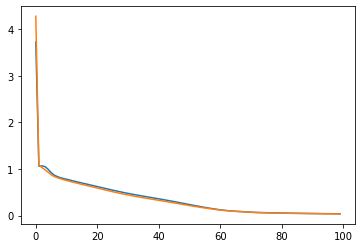

In [185]:
plt.plot(range(n_epochs//10), val_err)
plt.plot(range(n_epochs//10), train_err)

In [165]:
def evaluate_node(ypred, labels, train_idx, test_idx):
    _, pred_labels = torch.max(ypred, 2)
    pred_labels = pred_labels.numpy()

    pred_train = np.ravel(pred_labels[:, train_idx])
    pred_test = np.ravel(pred_labels[:, test_idx])
    labels_train = np.ravel(labels[:, train_idx])
    labels_test = np.ravel(labels[:, test_idx])

    result_train = {
        "prec": metrics.precision_score(labels_train, pred_train, average="macro"),
        "recall": metrics.recall_score(labels_train, pred_train, average="macro"),
        "acc": metrics.accuracy_score(labels_train, pred_train),
        "conf_mat": metrics.confusion_matrix(labels_train, pred_train),
    }
    result_test = {
        "prec": metrics.precision_score(labels_test, pred_test, average="macro"),
        "recall": metrics.recall_score(labels_test, pred_test, average="macro"),
        "acc": metrics.accuracy_score(labels_test, pred_test),
        "conf_mat": metrics.confusion_matrix(labels_test, pred_test),
    }
    return result_train, result_test


In [194]:
import sklearn.metrics as metrics

def gnn_scores(data):
    ypred = model(data.x, data.edge_index)
    yprob = model.get_proba(ypred)
    ylabels = model.get_labels(ypred)
    
    result_test = {
            "prec": metrics.precision_score(data.y[data.train_mask], ylabels[data.train_mask], average="macro"),
            "recall": metrics.recall_score(data.y[data.train_mask], ylabels[data.train_mask], average="macro"),
            "acc": metrics.accuracy_score(data.y[data.train_mask], ylabels[data.train_mask]),
            "conf_mat": metrics.confusion_matrix(data.y[data.train_mask], ylabels[data.train_mask]),
        }
    
    result_test = {
            "prec": metrics.precision_score(data.y[data.test_mask], ylabels[data.test_mask], average="macro"),
            "recall": metrics.recall_score(data.y[data.test_mask], ylabels[data.test_mask], average="macro"),
            "acc": metrics.accuracy_score(data.y[data.test_mask], ylabels[data.test_mask]),
            "conf_mat": metrics.confusion_matrix(data.y[data.test_mask], ylabels[data.test_mask]),
        }
    return result_train, result_test

In [196]:
gnn_scores(data)

/var/folders/2h/f06x9_xj7170hdxzgdbhs_7c0000gn/T/ipykernel_79343/1763337937.py:7: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/IndexingUtils.h:30.)
  "prec": metrics.precision_score(data.y[data.train_mask], ylabels[data.train_mask], average="macro"),
/var/folders/2h/f06x9_xj7170hdxzgdbhs_7c0000gn/T/ipykernel_79343/1763337937.py:8: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/IndexingUtils.h:30.)
  "recall": metrics.recall_score(data.y[data.train_mask], ylabels[data.train_mask], average="macro"),
/var/folders/2h/f06x9_xj7170hdxzgdbhs_7c0000gn/T/ipykernel_79343/1763337937.py:9: UserWarning: indexing with dtype torch.uint8 is now deprecated, please 

({'prec': 1.0,
  'recall': 1.0,
  'acc': 1.0,
  'conf_mat': array([[205,   0,   0,   0],
         [  0, 134,   0,   0],
         [  0,   0, 136,   0],
         [  0,   0,   0,  69]])},
 {'prec': 1.0,
  'recall': 1.0,
  'acc': 1.0,
  'conf_mat': array([[57,  0,  0,  0],
         [ 0, 47,  0,  0],
         [ 0,  0, 42,  0],
         [ 0,  0,  0, 14]])})

In [16]:
def list_to_dict(preds):
    preds_dict=pd.DataFrame(preds).to_dict('list')
    for key in preds_dict.keys():
        preds_dict[key] = np.array(preds_dict[key])
    return(preds_dict)


In [17]:
import torch
from torch_geometric.utils import k_hop_subgraph

def check_dir(save_dirs):
    if save_dirs:
        if os.path.isdir(save_dirs):
            pass
        else:
            os.makedirs(save_dirs)


def get_subgraph(node_idx, x, edge_index, num_hops, **kwargs):
    num_nodes, num_edges = x.size(0), edge_index.size(1)

    subset, edge_index, mapping, edge_mask = k_hop_subgraph(
        node_idx, num_hops, edge_index, relabel_nodes=True,
        num_nodes=num_nodes)

    x = x[subset]
    for key, item in kwargs.items():
        if torch.is_tensor(item) and item.size(0) == num_nodes:
            item = item[subset]
        elif torch.is_tensor(item) and item.size(0) == num_edges:
            item = item[edge_mask]
        kwargs[key] = item

    return x, edge_index, mapping, edge_mask, subset, kwargs


In [197]:
import numpy as np
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx
from subgraphx import SubgraphX
from gnnexplainer import TargetedGNNExplainer
from pgmexplainer import Node_Explainer
from typing import Union, Tuple, Any
from captum._utils.common import (
    _format_additional_forward_args,
    _format_input,
    _format_output,
)
from captum._utils.gradient import (
    apply_gradient_requirements,
    compute_layer_gradients_and_eval,
    undo_gradient_requirements,
)
from captum._utils.typing import TargetType
from captum.attr import Saliency, IntegratedGradients, LayerGradCam

def balance_mask_undirected(edge_mask, edge_index):
    balanced_edge_mask = np.zeros(len(edge_mask))
    num_edges = edge_index.shape[1]
    list_edges = edge_index.t().tolist()
    for i, (u, v) in enumerate(list_edges):
        if u > v:
            indices = [idx for idx in range(num_edges) if all(ele in list_edges[idx] for ele in [u, v])]
            if len(indices) == 2:
                balanced_edge_mask[indices] = np.max([edge_mask[indices[0]], edge_mask[indices[1]]])
    return balanced_edge_mask

def mask_to_directed(edge_mask, edge_index):
    directed_edge_mask = edge_mask.copy()
    for i, (u, v) in enumerate(edge_index.t().tolist()):
        if u > v:
            directed_edge_mask[i]=0
    return directed_edge_mask

class GraphLayerGradCam(LayerGradCam):

    def attribute(self, inputs: Union[Tensor, Tuple[Tensor, ...]], target: TargetType = None,
                  additional_forward_args: Any = None, attribute_to_layer_input: bool = False,
                  relu_attributions: bool = False) -> Union[Tensor, Tuple[Tensor, ...]]:
        inputs = _format_input(inputs)
        additional_forward_args = _format_additional_forward_args(
            additional_forward_args
        )
        gradient_mask = apply_gradient_requirements(inputs)
        # Returns gradient of output with respect to
        # hidden layer and hidden layer evaluated at each input.
        layer_gradients, layer_evals = compute_layer_gradients_and_eval(
            self.forward_func,
            self.layer,
            inputs,
            target,
            additional_forward_args,
            device_ids=self.device_ids,
            attribute_to_layer_input=attribute_to_layer_input,
        )
        undo_gradient_requirements(inputs, gradient_mask)

        summed_grads = tuple(
            torch.mean(
                layer_grad,
                dim=0,
                keepdim=True,
            )
            for layer_grad in layer_gradients
        )

        scaled_acts = tuple(
            torch.sum(summed_grad * layer_eval, dim=1, keepdim=True)
            for summed_grad, layer_eval in zip(summed_grads, layer_evals)
        )
        if relu_attributions:
            scaled_acts = tuple(F.relu(scaled_act) for scaled_act in scaled_acts)
        return _format_output(len(scaled_acts) > 1, scaled_acts)


def model_forward(edge_mask, model, node_idx, x, edge_index):
    out = model(x, edge_index, edge_mask)
    return out[[node_idx]]

def model_forward_node(x, model, edge_index, node_idx):
    out = model(x, edge_index)
    return out[[node_idx]]

def node_attr_to_edge(edge_index, node_mask):
    edge_mask = np.zeros(edge_index.shape[1])
    edge_mask += node_mask[edge_index[0].cpu().numpy()]
    edge_mask += node_mask[edge_index[1].cpu().numpy()]
    return edge_mask

def get_all_convolution_layers(model):
    layers = []
    for module in model.modules():
        if isinstance(module, MessagePassing):
            layers.append(module)
    return layers


In [198]:
from sklearn import metrics

def topk_edges_directed(edge_mask, edge_index, num_top_edges):
    indices = (-edge_mask).argsort()
    top = np.array([], dtype='int')
    i = 0
    list_edges = np.sort(edge_index.T, axis=1)
    while len(top)<num_top_edges:
        subset = indices[num_top_edges*i:num_top_edges*(i+1)]
        topk_edges = list_edges[subset]
        u, idx = np.unique(topk_edges, return_index=True, axis=0)
        top = np.concatenate([top, subset[idx]], dtype=np.int32)
        i+=1
    return top[:num_top_edges]

def normalize_mask(x):
    return (x - min(x)) / (max(x) - min(x))


#transform edge_mask:
# normalisation
# sparsity
# hard or soft
def transform_mask(mask, sparsity=0.7, normalize=True, hard_mask=False):
    if sparsity is not None:
        mask = control_sparsity(mask, sparsity)
    if normalize:
        mask = normalize_mask(mask)
    if hard_mask:
        mask = np.where(mask>0, 1, 0)
    return(mask)

def mask_to_shape(mask, edge_index, num_top_edges):
    indices = topk_edges_directed(mask, edge_index, num_top_edges)
    new_mask = np.zeros(len(mask))
    new_mask[indices] = 1
    return new_mask

def control_sparsity(mask, sparsity):
    r"""
        :param edge_mask: mask that need to transform
        :param sparsity: sparsity we need to control i.e. 0.7, 0.5
        :return: transformed mask where top 1 - sparsity values are set to inf.
    """
    mask_len = len(mask)
    split_point = int((1 - sparsity) * mask_len)
    unimportant_indices = (-mask).argsort()[split_point:]
    mask[unimportant_indices] = 0
    return mask


##### Accuracy #####
def get_explanation(data, edge_mask, num_top_edges):
    edge_mask = mask_to_shape(edge_mask, data.edge_index, num_top_edges)
    indices = np.where(edge_mask>0)[0]
    #indices = (-edge_mask).argsort()[:num_top_edges]
    explanation = data.edge_index[:, indices]
    G_expl = nx.Graph()
    G_expl.add_nodes_from(np.unique(explanation))
    for i, (u, v) in enumerate(explanation.t().tolist()):
        G_expl.add_edge(u, v)
    return (G_expl)

def get_ground_truth_ba_shapes(node, data):
    base = [0, 1, 2, 3, 4]
    offset = node % 5
    ground_truth = [node - offset + val for val in base]
    start = ground_truth[0]
    graph, role = house(start, role_start=1)

    true_node_mask = np.zeros(data.edge_index.shape[1])
    true_node_mask[ground_truth] = 1
    true_edge_mask = node_attr_to_edge(data.edge_index, true_node_mask)

    return graph, role, true_edge_mask


def get_scores(G1, G2):
    G1, G2 = G1.to_undirected(), G2.to_undirected()
    g_int = nx.intersection(G1, G2)
    g_int.remove_nodes_from(list(nx.isolates(g_int)))

    n_tp = g_int.number_of_edges()
    n_fp = len(G1.edges() - g_int.edges())
    n_fn = len(G2.edges() - g_int.edges())

    precision = n_tp / (n_tp + n_fp)
    recall = n_tp / (n_tp + n_fn)
    if n_tp == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    ged = nx.graph_edit_distance(G1, G2)

    return recall, precision, f1_score, ged

def get_accuracy(data, edge_mask, node_idx, num_top_edges):
    G_true, role, true_edge_mask = get_ground_truth_ba_shapes(node_idx, data)
    # nx.draw(G_true, cmap=plt.get_cmap('viridis'), node_color=role, with_labels=True, font_weight='bold')
    G_expl = get_explanation(data, edge_mask, num_top_edges)
    plt.figure()
    nx.draw(G_expl, with_labels=True, font_weight='bold')
    plt.show()
    # plt.clf()
    recall, precision, f1_score, ged = get_scores(G_expl, G_true)
    fpr, tpr, thresholds = metrics.roc_curve(true_edge_mask, edge_mask, pos_label=2)
    auc = metrics.auc(fpr, tpr)
    return {'recall': recall, 'precision': precision, 'f1_score': f1_score, 'ged': ged, 'auc': auc}


def eval_accuracy(data, edge_masks, list_node_idx, num_top_edges):
    n_test = len(list_node_idx)
    scores = []

    for i in range(n_test):
        edge_mask = torch.Tensor(edge_masks[i])
        node_idx = list_node_idx[i]
        entry = get_accuracy(data, edge_mask, node_idx, num_top_edges)
        scores.append(entry)

    scores = list_to_dict(scores)
    accuracy_scores = {k: np.mean(v) for k, v in scores.items()}
    return (accuracy_scores)

In [211]:
from scipy.special import softmax

##### Fidelity #####
def eval_related_pred(model, data, edge_masks, list_node_idx, params):
    related_preds = []
    masks_sparsity = []

    #ori_preds = model(data.x, data.edge_index)
    n_test = len(list_node_idx)

    for i in range(n_test):

        edge_mask = torch.Tensor(edge_masks[i])
        node_idx = list_node_idx[i]
        mask_sparsity = 1.0 - (edge_mask != 0).sum() / edge_mask.size(0)
        edge_mask = transform_mask(edge_mask, sparsity=params['sparsity'],
                                   normalize=params['normalize'], hard_mask=params['hard_mask'])

        sub_x, sub_edge_index, mapping, hard_edge_mask, subset, _ = get_subgraph(node_idx, data.x, data.edge_index, 2)
        ori_preds = model(sub_x, sub_edge_index)
        sub_masked_x, sub_maskout_x = sub_x, sub_x

        sub_edge_mask = edge_mask[hard_edge_mask]

        indices = np.where(sub_edge_mask>0)[0]
        indices_inv = [i for i in range(len(sub_edge_mask)) if i not in indices]

        sub_masked_edge_index = sub_edge_index[:, indices]
        sub_maskout_edge_index = sub_edge_index[:, indices_inv]

        def masking(indices):
            masked_edge_index = data.edge_index[:, indices]
            masked_nodes = torch.LongTensor(np.unique(masked_edge_index))
            if node_idx not in masked_nodes:
                masked_nodes = torch.cat([torch.LongTensor([node_idx]), masked_nodes])
            # Function to be vectorized
            def map_func(val, dictionary):
                return dictionary[val] if val in dictionary else val
            vfunc = np.vectorize(map_func)
            d = {v.item(): k for k, v in enumerate(masked_nodes)}
            sub_masked_edge_index = torch.LongTensor(vfunc(masked_edge_index, d))
            masked_node_idx = int(vfunc(node_idx, d))
            sub_masked_x = torch.FloatTensor([[1]] * len(masked_nodes))
            return sub_masked_x, sub_masked_edge_index, masked_node_idx

        #sub_masked_x, sub_masked_edge_index, masked_node_idx = masking(indices)
        #sub_maskout_x, sub_maskout_edge_index, maskout_node_idx = masking(indices_inv)


        if params['hard_mask']:
            masked_preds = model(sub_masked_x, sub_masked_edge_index)
            maskout_preds = model(sub_maskout_x, sub_maskout_edge_index)

            #masked_preds = model(data.x, data.edge_index[:, indices])
            #maskout_preds = model(data.x, data.edge_index[:, indices_inv])

        else:
            masked_preds = model(sub_masked_x, sub_masked_edge_index, edge_weight=edge_mask[indices])
            maskout_preds = model(sub_maskout_x, sub_maskout_edge_index, edge_weight=(1-edge_mask)[indices_inv])

            #masked_preds = model(data.x, data.edge_index[:, indices], edge_weight=edge_mask[indices])
            #maskout_preds = model(data.x, data.edge_index[:, indices_inv], edge_weight=(1-edge_mask)[indices_inv])

        #ori_probs = softmax(ori_preds[node_idx].detach().numpy())
        #ori_probs = softmax(ori_preds[mapping].detach().numpy())
        #masked_probs = softmax(masked_preds[mapping].detach().numpy())
        #maskout_probs = softmax(maskout_preds[mapping].detach().numpy())

        ori_probs = ori_preds[mapping].detach().numpy()
        masked_probs = masked_preds[mapping].detach().numpy()
        maskout_probs = maskout_preds[mapping].detach().numpy()

        #print('masked label', masked_probs.argmax())

        true_label = data.y[node_idx].detach().numpy()
        pred_label = np.argmax(ori_probs)
        print('true_label', true_label)
        print('pred_label', pred_label)
        #assert true_label == pred_label, "The label predicted by the GCN does not match the true label."

        related_preds.append({'node_idx': node_idx,
                                  'masked': masked_probs,
                                  'maskout': maskout_probs,
                                  'origin': ori_probs,
                                  'sparsity': mask_sparsity,
                                  'true_label': true_label,
                              'pred_label': pred_label})

    related_preds = list_to_dict(related_preds)
    return related_preds


def eval_related_pred(model, data, edge_masks, list_node_idx):
    related_preds = []
    masks_sparsity = []

    ori_ypred = model(data.x, data.edge_index)
    ori_yprob = model.get_proba(ori_ypred)
        
    n_test = len(list_node_idx)

    for i in range(n_test):

        edge_mask = torch.Tensor(edge_masks[i])
        node_idx = list_node_idx[i]
        mask_sparsity = 1.0 - (edge_mask != 0).sum() / edge_mask.size(0)
        #edge_mask = transform_mask(edge_mask, sparsity=params['sparsity'],
                                   #normalize=params['normalize'], hard_mask=params['hard_mask'])


        indices = np.where(edge_mask>0)[0]
        indices_inv = [i for i in range(len(edge_mask)) if i not in indices]

        masked_edge_index = data.edge_index[:, indices]
        maskout_edge_index = data.edge_index[:, indices_inv]
        
        masked_ypred = model(data.x, masked_edge_index)
        masked_yprob = model.get_proba(masked_ypred)
        
        
        maskout_ypred = model(data.x, maskout_edge_index)
        maskout_yprob = model.get_proba(maskout_ypred)
        
        
        ori_probs = ori_yprob[node_idx].detach().numpy()
        masked_probs = masked_yprob[node_idx].detach().numpy()
        maskout_probs = maskout_yprob[node_idx].detach().numpy()

        true_label = data.y[node_idx].detach().numpy()
        pred_label = np.argmax(ori_probs)
        #assert true_label == pred_label, "The label predicted by the GCN does not match the true label."

        related_preds.append({'node_idx': node_idx,
                                  'masked': masked_probs,
                                  'maskout': maskout_probs,
                                  'origin': ori_probs,
                                  'sparsity': mask_sparsity,
                                  'true_label': true_label,
                              'pred_label': pred_label})

    related_preds = list_to_dict(related_preds)
    return related_preds


def fidelity_acc(related_preds):
    labels = related_preds['true_label']
    ori_labels = np.argmax(related_preds['origin'], axis=1)
    unimportant_labels = np.argmax(related_preds['maskout'], axis=1)
    p_1 = np.array(ori_labels == labels).astype(int)
    p_2 = np.array(unimportant_labels == labels).astype(int)
    drop_probability = p_1 - p_2
    return drop_probability.mean().item()


def fidelity_acc_inv(related_preds):
    labels = related_preds['true_label']
    ori_labels = np.argmax(related_preds['origin'], axis=1)
    important_labels = np.argmax(related_preds['masked'], axis=1)
    p_1 = np.array([ori_labels == labels]).astype(int)
    p_2 = np.array([important_labels == labels]).astype(int)
    drop_probability = p_1 - p_2
    return drop_probability.mean().item()


# Fidelity+  metric  studies  the  prediction  change  by
# removing  important  nodes/edges/node  features.
# Higher fidelity+ value indicates good explanations -->1
def fidelity_prob(related_preds):
    labels = related_preds['true_label']
    ori_probs = np.choose(labels, related_preds['origin'].T)
    unimportant_probs = np.choose(labels, related_preds['maskout'].T)
    drop_probability = ori_probs - unimportant_probs
    return drop_probability.mean().item()

# Fidelity-  metric  studies  the  prediction  change  by
# removing  unimportant  nodes/edges/node  features.
# Lower fidelity- value indicates good explanations -->0
def fidelity_prob_inv(related_preds):
    labels = related_preds['true_label']
    ori_probs = np.choose(labels, related_preds['origin'].T)
    important_probs = np.choose(labels, related_preds['masked'].T)
    drop_probability = ori_probs - important_probs
    return drop_probability.mean().item()

def eval_fidelity(related_preds, params):
    fidelity_scores = {
        "fidelity_acc+": fidelity_acc(related_preds),
        "fidelity_acc-": fidelity_acc_inv(related_preds),
        "fidelity_prob+": fidelity_prob(related_preds),
        "fidelity_prob-": fidelity_prob_inv(related_preds),
    }
    return dict(list(params.items()) + list(fidelity_scores.items()))


def eval_fidelity(related_preds):
    fidelity_scores = {
        "fidelity_acc+": fidelity_acc(related_preds),
        "fidelity_acc-": fidelity_acc_inv(related_preds),
        "fidelity_prob+": fidelity_prob(related_preds),
        "fidelity_prob-": fidelity_prob_inv(related_preds),
    }
    return fidelity_scores

In [20]:
def normalize(x):
    return (x-min(x))/(max(x)-min(x))
def normalize_masks(edge_masks):
    new_list = []
    for mask in edge_masks:
        new_list.append(normalize(mask))
    return new_list

In [ ]:
import random 
random.seed(1)
pred = model(data.x, data.edge_index).argmax(dim=1)
list_node_idx = np.where(pred == data.y)[0]
list_node_idx_house = list_node_idx[list_node_idx>n_basis]
test_nodes = [x.item() for x in random.choices(list_node_idx_house, k=10)]

### GNNExplainer

In [147]:
from scipy.special import softmax

def gnn_model(model, x, edge_index):
    h = x.expand(1,-1,-1) #* self.node_feat_mask.sigmoid()
    max_n = x.size(0)
    edge_index = edge_index.expand(1,-1,-1)
    ypred = model(h, edge_index)
    ypred = np.squeeze(ypred.detach().numpy(), axis=0)
    yprob = softmax(ypred, axis = 1)
    ylabels = np.argmax(ypred, 1)
    return ypred, yprob, ylabels

In [200]:
import torch
from torch_geometric.nn import GNNExplainer
from tqdm import tqdm
from scipy.special import softmax

EPS = 1e-15


class TargetedGNNExplainer(GNNExplainer):
    def __loss__(self, node_idx, log_logits, target_class):
        loss = -log_logits[node_idx, target_class]

        m = self.edge_mask.sigmoid()
        loss = loss + self.coeffs['edge_size'] * m.sum()
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['edge_ent'] * ent.mean()

        """
        m = self.node_feat_mask.sigmoid()
        loss = loss + self.coeffs['node_feat_size'] * m.sum()
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()
        """

        return loss

    def explain_node_with_target(self, node_idx, x, edge_index, target, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for node
        :attr:`node_idx`.

        Args:
            node_idx (int): The node to explain.
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self.__clear_masks__()

        num_nodes = x.size(0)
        num_edges = edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        x, edge_index, mapping, hard_edge_mask, subset, kwargs = \
            self.__subgraph__(node_idx, x, edge_index, **kwargs)

        # Get the initial prediction.
        # Get the initial prediction.
        if target is None:
            with torch.no_grad():
                out = self.model(x, edge_index)
                if self.return_type == 'regression':
                    prediction = out
                else:
                    log_logits = self.__to_log_prob__(out)
                    pred_label = log_logits.argmax(dim=-1)
        else:
            if self.return_type == 'regression':
                prediction = target
            else:
                pred_label = target

        self.__set_masks__(x, edge_index)
        self.to(x.device)

        if self.allow_edge_mask:
            parameters = [self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description(f'Explain node {node_idx}')

        for epoch in range(1, 800):#self.epochs + 1):
            optimizer.zero_grad()
            out = self.model(x, edge_index)
            if self.return_type == 'regression':
                loss = self.__loss__(mapping, out, prediction)
            else:
                log_logits = self.__to_log_prob__(out)
                loss = self.__loss__(mapping, log_logits, pred_label)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        """
        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        if self.feat_mask_type == 'individual_feature':
            new_mask = x.new_zeros(num_nodes, x.size(-1))
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        elif self.feat_mask_type == 'scalar':
            new_mask = x.new_zeros(num_nodes, 1)
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        node_feat_mask = node_feat_mask.squeeze()
        """

        edge_mask = self.edge_mask.new_zeros(num_edges)
        edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()

        #return node_feat_mask, edge_mask
        return edge_mask



In [201]:
def explain_gnnexplainer(model, node_idx, x, edge_index, target, device, include_edges=None):
    explainer = TargetedGNNExplainer(model, num_hops=3)
    if node_idx is not None:
        edge_mask = explainer.explain_node_with_target(node_idx, x=x, edge_index=edge_index, target=target)
    edge_mask = edge_mask.detach().numpy()
    return edge_mask

In [202]:
n_basis, n_shapes = 2000, 1000

data = build_data(n_basis, n_shapes)

In [59]:
model.eval()

GcnEncoderNode(
  (conv_first): GraphConv()
  (conv_block): ModuleList(
    (0): GraphConv()
  )
  (conv_last): GraphConv()
  (act): ReLU()
  (pred_model): Linear(in_features=60, out_features=4, bias=True)
  (celoss): CrossEntropyLoss()
)

In [204]:
from torch_geometric.nn import GNNExplainer
import random

list_test_nodes = range(n_basis, n_basis+n_shapes*5)
edge_masks = []

#explainer = GNNExplainer(model)
for node_idx in list_test_nodes[:10]:
    x_c = torch.FloatTensor(data.x.detach().numpy().copy())
    edge_index_c = torch.LongTensor(data.edge_index.detach().numpy().copy())
    target = int(data.y[node_idx])
    print(node_idx)
    
    #node_feat_mask, edge_mask = explainer.explain_node(node_idx, x = data.x, edge_index = data.edge_index)
    #node_feat_mask, edge_mask = node_feat_mask.detach().numpy(), edge_mask.detach().numpy()
    
    edge_mask = explain_gnnexplainer(model, node_idx, x_c, edge_index_c, target, device)
    
    edge_masks.append(edge_mask)
    indices = (-edge_mask).argsort()[:6]
    print(edge_index_c[:,indices])
    

2000


Explain node 2000: : 799it [00:01, 646.83it/s]                                                                                                                           


tensor([[  39,   65,   98,    6,  130, 1443],
        [1924,    7,    9,   15, 2973,   39]])
2001


Explain node 2001: : 799it [00:00, 909.28it/s]                                                                                                                           


tensor([[ 197,  108, 2000, 2000,  640,  130],
        [ 302,  302, 2004,  302,  302,  302]])
2002


Explain node 2002: : 799it [00:00, 939.25it/s]                                                                                                                           


tensor([[2001, 2002, 2001, 2000, 2000, 2003],
        [2004, 2003, 2000, 2001, 2003, 2002]])
2003


Explain node 2003: : 799it [00:00, 919.92it/s]                                                                                                                           


tensor([[2002, 2001,   14,  302,  108,  302],
        [2001, 2000,   39,  108,  302,  130]])
2004


Explain node 2004: : 799it [00:00, 861.27it/s]                                                                                                                           


tensor([[ 108, 2002, 2000,   14,  989,   39],
        [ 302, 2001, 2004,   39,  302,   14]])
2005


Explain node 2005: : 799it [00:00, 903.36it/s]                                                                                                                           


tensor([[1922, 1489, 2009, 2008, 2007, 1489],
        [ 955, 1922, 2006, 2005, 2008,  289]])
2006


Explain node 2006: : 799it [00:00, 856.85it/s]                                                                                                                           


tensor([[ 439,   35,  300,    7,  244,  300],
        [1048,  289,  594,   35,   35, 1431]])
2007


Explain node 2007: : 799it [00:00, 891.07it/s]                                                                                                                           


tensor([[2009, 1922, 1922, 1922, 2009, 2006],
        [2005,  300, 1489,  955, 2006, 2005]])
2008


Explain node 2008: : 799it [00:00, 896.99it/s]                                                                                                                           


tensor([[2009, 2007, 2005, 2009, 1922, 2008],
        [2005, 2008, 2009, 2006, 2006, 2005]])
2009


Explain node 2009: : 799it [00:00, 896.22it/s]                                                                                                                           

tensor([[2006, 1922, 1922, 2008, 1922, 2009],
        [1922, 1048,  289, 2005, 1489, 2006]])


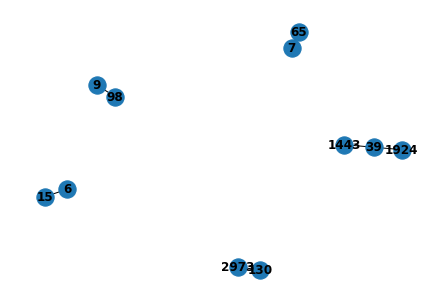

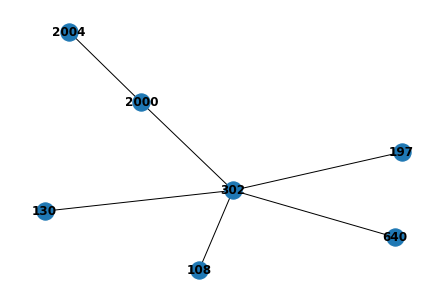

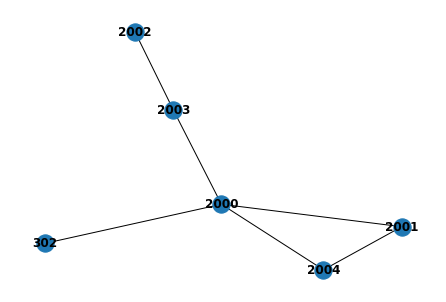

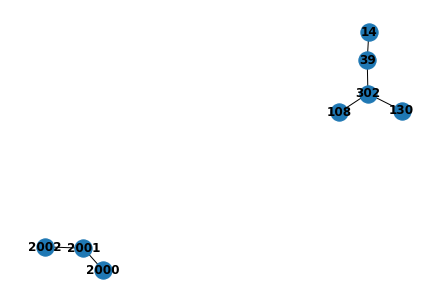

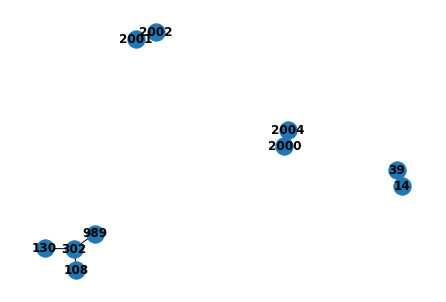

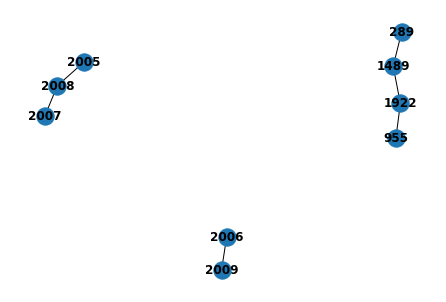

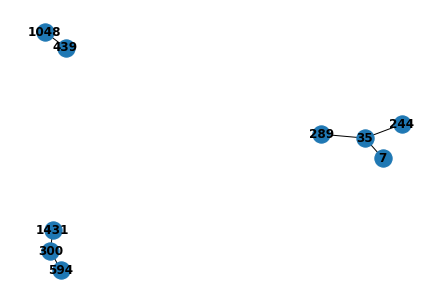

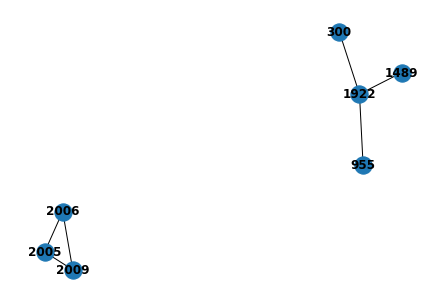

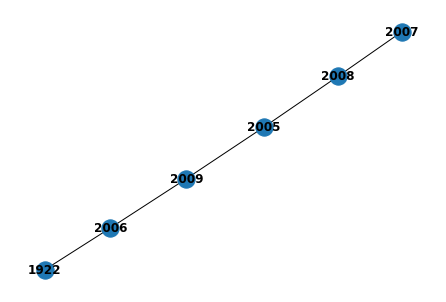

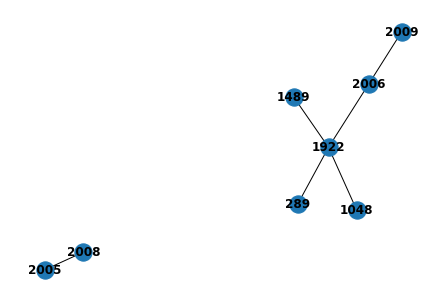

{'recall': 0.3666666666666667,
 'precision': 0.38,
 'f1_score': 0.37272727272727274,
 'ged': 7.6,
 'auc': 0.9980589604573045}

In [205]:
acc = eval_accuracy(data, edge_masks, list_test_nodes[:10], num_top_edges=6)
acc

In [212]:
related_preds = eval_related_pred(model, data, edge_masks, list_test_nodes[:10])
eval_fidelity(related_preds)

{'fidelity_acc+': 0.6,
 'fidelity_acc-': 0.0,
 'fidelity_prob+': 0.5724374055862427,
 'fidelity_prob-': 0.0}

### Saliency

In [213]:
def explain_sa(model, node_idx, x, edge_index, target, include_edges=None):
    saliency = Saliency(model_forward)
    input_mask = torch.ones(edge_index.shape[1]).requires_grad_(True).to(device)
    saliency_mask = saliency.attribute(input_mask, target=target,
                                       additional_forward_args=(model, node_idx, x, edge_index), abs=False)

    edge_mask = saliency_mask.cpu().numpy()
    return edge_mask

def explain_sa_node(model, node_idx, x, edge_index, target, include_edges=None):
    saliency = Saliency(model_forward_node)
    input_mask = x.clone().requires_grad_(True).to(device)
    saliency_mask = saliency.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx),
                                       abs=False)

    node_attr = saliency_mask.cpu().numpy().sum(axis=1)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

In [214]:
list_test_nodes = range(n_basis, n_basis+n_shapes*5)
edge_masks = []

#explainer = GNNExplainer(model)
for node_idx in list_test_nodes[:10]:
    x_c = torch.FloatTensor(data.x.detach().numpy().copy())
    edge_index_c = torch.LongTensor(data.edge_index.detach().numpy().copy())
    target = int(data.y[node_idx])
    print(node_idx)
    edge_mask = explain_sa_node(model, node_idx, x_c, edge_index_c, target, device)
    
    edge_masks.append(edge_mask)
    indices = (-edge_mask).argsort()[:6]
    print(edge_index_c[:,indices])

2000
tensor([[197, 302, 316, 302, 302, 989],
        [302, 108, 302, 130, 197, 302]])
2001
tensor([[2004, 2000, 2000, 2001,  302, 2000],
        [2000, 2004, 2001, 2000, 2000,  302]])
2002
tensor([[2000, 2004, 2003, 2002, 2002, 2001],
        [2004, 2000, 2002, 2003, 2001, 2002]])
2003
tensor([[2000, 2001, 2004, 2000, 2000,  302],
        [2001, 2000, 2000, 2004,  302, 2000]])
2004
tensor([[130,  39, 302, 302, 302, 197],
        [302, 302,  14,  39, 108, 302]])
2005
tensor([[2006, 2009, 2005, 2006, 2006, 1922],
        [2009, 2006, 2006, 2005, 1922, 2006]])
2006
tensor([[ 300, 1922,  955, 1922, 1048, 1922],
        [1922, 1048, 1922,  955, 1922,  300]])
2007
tensor([[ 289, 1489, 1048,  164,  244,  594],
        [1489,  289,    7,  300,  289,  300]])
2008
tensor([[2009, 2006, 2008, 2007, 2008, 2005],
        [2006, 2009, 2007, 2008, 2005, 2008]])
2009
tensor([[1922, 1922, 1922, 1048,  289,  955],
        [1489,  300,  289, 1922, 1922, 1922]])


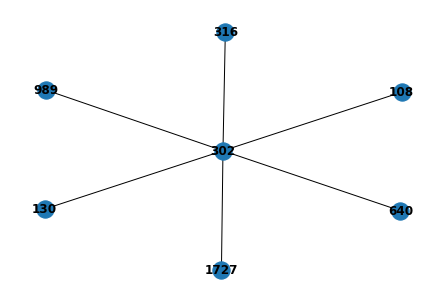

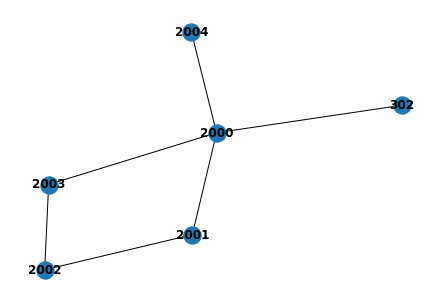

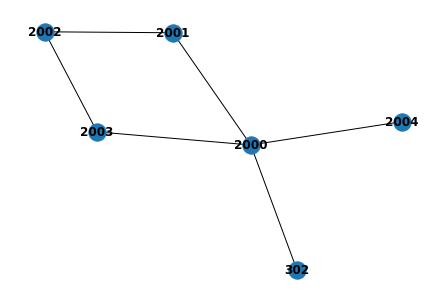

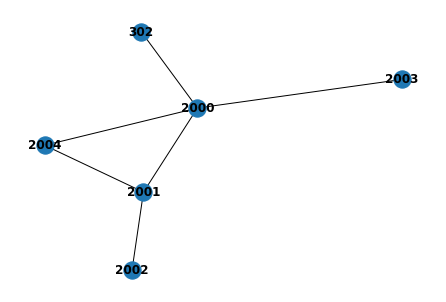

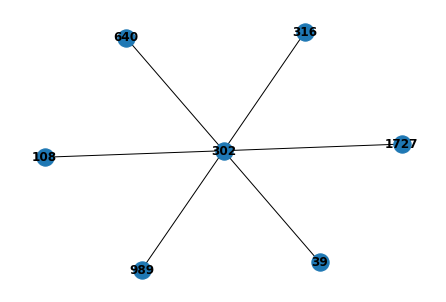

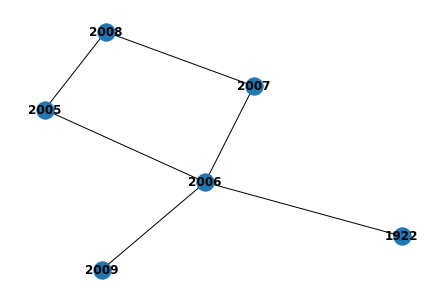

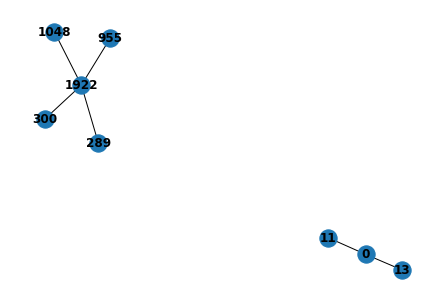

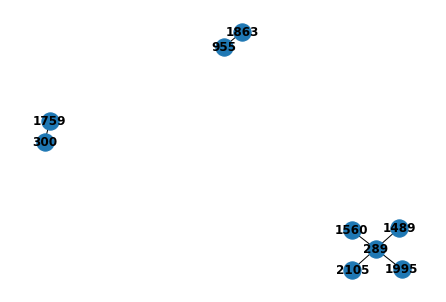

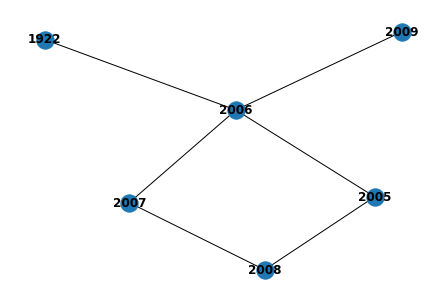

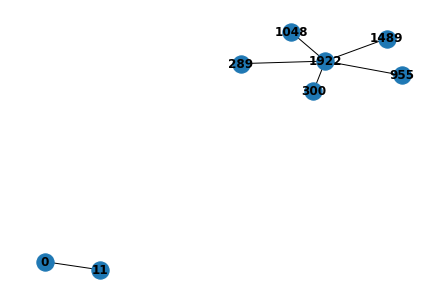

{'recall': 0.4166666666666667,
 'precision': 0.4166666666666667,
 'f1_score': 0.4166666666666667,
 'ged': 5.9,
 'auc': 0.4833028856542322}

In [215]:
acc = eval_accuracy(data, edge_masks, list_test_nodes[:10], num_top_edges=6)
acc

In [216]:
related_preds = eval_related_pred(model, data, edge_masks, list_test_nodes[:10])
eval_fidelity(related_preds)

{'fidelity_acc+': 0.2,
 'fidelity_acc-': 0.5,
 'fidelity_prob+': 0.1768413484096527,
 'fidelity_prob-': 0.4995701313018799}

In [ ]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

In [ ]:
def explain_ig_node(model, node_idx, x, edge_index, target, include_edges=None):
    ig = IntegratedGradients(model_forward_node)
    input_mask = x.clone().requires_grad_(True).to(device)
    ig_mask = ig.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx),
                           internal_batch_size=input_mask.shape[0])

    node_attr = ig_mask.cpu().detach().numpy().sum(axis=1)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

In [ ]:
edge_masks = []

for node_idx in test_nodes:
    edge_mask = explain_ig_node(model, node_idx, data.x, data.edge_index, labels[node_idx])
    #print(edge_mask[np.where(edge_mask>0)[0]])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    edge_masks.append(edge_mask)    

In [ ]:
soft_related_preds = eval_related_pred(model, data, edge_masks, test_nodes, hard_mask=False)
hard_related_preds = eval_related_pred(model, data, edge_masks, test_nodes, hard_mask=True, num_top_edges=6)


In [ ]:
acc = eval_accuracy(data, edge_masks, test_nodes, num_top_edges=6, is_hard_mask=False)
f1 = eval_fidelity(soft_related_preds)
f2 = eval_fidelity(hard_related_preds)

In [ ]:
f1 = eval_fidelity(soft_related_preds)
f1 = {k+'_soft':v for k,v in f1.items()}
f1

In [ ]:
f2 = eval_fidelity(hard_related_preds)
f2

In [ ]:
def explain_occlusion(model, node_idx, x, edge_index, target, include_edges=None):
    depth_limit = model.num_layers + 1
    data = Data(x=x, edge_index=edge_index)
    pred_prob = model(data.x, data.edge_index)[node_idx][target].item()
    g = to_networkx(data)
    subgraph_nodes = []
    for k, v in nx.shortest_path_length(g, target=node_idx).items():
        if v < depth_limit:
            subgraph_nodes.append(k)
    subgraph = g.subgraph(subgraph_nodes)
    edge_occlusion_mask = np.ones(data.num_edges, dtype=bool)
    edge_mask = np.zeros(data.num_edges)
    edge_index_numpy = data.edge_index.cpu().numpy()
    for i in range(data.num_edges):
        if include_edges is not None and not include_edges[i].item():
            continue
        u, v = list(edge_index_numpy[:, i])
        if (u, v) in subgraph.edges():
            edge_occlusion_mask[i] = False
            prob = model(data.x, data.edge_index[:, edge_occlusion_mask])[node_idx][target].item()
            edge_mask[i] = pred_prob - prob
            edge_occlusion_mask[i] = True
    return edge_mask


In [ ]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

for node_idx in list_node_idx:
    edge_mask = explain_occlusion(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [ ]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Node_Explainer:
    def __init__(
            self,
            model,
            edge_index,
            X,
            num_layers,
            mode=0,
            print_result=1
    ):
        self.model = model
        self.model.eval()
        self.edge_index = edge_index
        self.X = X
        self.num_layers = num_layers
        self.mode = mode
        self.print_result = print_result

    def perturb_features_on_node(self, feature_matrix, node_idx, random=0, mode=0):
        # return a random perturbed feature matrix
        # random = 0 for nothing, 1 for random.
        # mode = 0 for random 0-1, 1 for scaling with original feature

        X_perturb = feature_matrix
        if mode == 0:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.random.randint(2, size=X_perturb[node_idx].shape[0])
            X_perturb[node_idx] = perturb_array
        elif mode == 1:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.multiply(X_perturb[node_idx],
                                            np.random.uniform(low=0.0, high=2.0, size=X_perturb[node_idx].shape[0]))
            X_perturb[node_idx] = perturb_array
        return X_perturb

    def explain(self, node_idx, target, num_samples=100, top_node=None, p_threshold=0.05, pred_threshold=0.1):
        neighbors, _, _, _ = k_hop_subgraph(node_idx, self.num_layers, self.edge_index)
        neighbors = neighbors.cpu().detach().numpy()

        if (node_idx not in neighbors):
            neighbors = np.append(neighbors, node_idx)

        pred_torch = self.model(self.X, self.edge_index).cpu()
        soft_pred = np.asarray([softmax(np.asarray(pred_torch[node_].data)) for node_ in range(self.X.shape[0])])

        pred_node = np.asarray(pred_torch[node_idx].data)
        label_node = np.argmax(pred_node)
        soft_pred_node = softmax(pred_node)

        Samples = []
        Pred_Samples = []

        for iteration in range(num_samples):

            X_perturb = self.X.cpu().detach().numpy()
            sample = []
            for node in neighbors:
                seed = np.random.randint(2)
                if seed == 1:
                    latent = 1
                    X_perturb = self.perturb_features_on_node(X_perturb, node, random=seed)
                else:
                    latent = 0
                sample.append(latent)

            X_perturb_torch = torch.tensor(X_perturb, dtype=torch.float).to(device)
            pred_perturb_torch = self.model(X_perturb_torch, self.edge_index).cpu()
            soft_pred_perturb = np.asarray(
                [softmax(np.asarray(pred_perturb_torch[node_].data)) for node_ in range(self.X.shape[0])])

            sample_bool = []
            for node in neighbors:
                if (soft_pred_perturb[node, target] + pred_threshold) < soft_pred[node, target]:
                    sample_bool.append(1)
                else:
                    sample_bool.append(0)

            Samples.append(sample)
            Pred_Samples.append(sample_bool)

        Samples = np.asarray(Samples)
        Pred_Samples = np.asarray(Pred_Samples)
        Combine_Samples = Samples - Samples
        for s in range(Samples.shape[0]):
            Combine_Samples[s] = np.asarray(
                [Samples[s, i] * 10 + Pred_Samples[s, i] + 1 for i in range(Samples.shape[1])])

        data_pgm = pd.DataFrame(Combine_Samples)
        data_pgm = data_pgm.rename(columns={0: 'A', 1: 'B'})  # Trick to use chi_square test on first two data columns
        ind_ori_to_sub = dict(zip(neighbors, list(data_pgm.columns)))

        p_values = []
        for node in neighbors:
            if node == node_idx:
                p = 0 # p<0.05 => we are confident that we can reject the null hypothesis (i.e. the prediction is the same after perturbing the neighbouring node 
                # => this neighbour has no influence on the prediction - should not be in the explanation)
            else:
                chi2, p,_ = chi_square(ind_ori_to_sub[node], ind_ori_to_sub[node_idx], [], data_pgm, boolean=False, significance_level=0.05)
            p_values.append(p)

        pgm_stats = dict(zip(neighbors, p_values))
        return pgm_stats

In [ ]:
def explain_pgmexplainer(model, node_idx, x, edge_index, target, include_edges=None):
    explainer = Node_Explainer(model, edge_index, x, model.num_layers, print_result=0)
    explanation = explainer.explain(node_idx,target)
    node_attr = np.zeros(x.shape[0])
    for node, p_value in explanation.items():
        node_attr[node] = 1 - p_value
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

In [ ]:
import time 


list_node_idx = range(n_basis,n_basis+3)#*n_shapes)

duration_samples = []
edge_masks = []



for node_idx in test_nodes[:3]:
    start_time = time.time()
    edge_mask = explain_pgmexplainer(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    edge_masks.append(edge_mask)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    


In [ ]:
soft_related_preds = eval_related_pred(model, data, edge_masks, test_nodes[:3], hard_mask=False)
hard_related_preds = eval_related_pred(model, data, edge_masks, test_nodes[:3], hard_mask=True, num_top_edges=6)

acc = eval_accuracy(data, edge_masks, test_nodes, num_top_edges=6, is_hard_mask=False)
f1 = eval_fidelity(soft_related_preds)
f2 = eval_fidelity(hard_related_preds)

In [ ]:
print(acc, f1, f2)

In [ ]:
def explain_random(model, node_idx, x, edge_index, target, include_edges=None):
    return np.random.uniform(size=edge_index.shape[1])

In [ ]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_random(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [ ]:
def explain_distance(model, node_idx, x, edge_index, target, include_edges=None):
    data = Data(x=x, edge_index=edge_index)
    g = to_networkx(data)
    length = nx.shortest_path_length(g, target=node_idx)

    def get_attr(node):
        if node in length:
            return 1 / (length[node] + 1)
        return 0

    edge_sources = edge_index[1].cpu().numpy()
    return np.array([get_attr(node) for node in edge_sources])

In [ ]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_distance(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [ ]:
def explain_pagerank(model, node_idx, x, edge_index, target, include_edges=None):
    data = Data(x=x, edge_index=edge_index)
    g = to_networkx(data)
    pagerank = nx.pagerank(g, personalization={node_idx: 1})

    node_attr = np.zeros(x.shape[0])
    for node, value in pagerank.items():
        node_attr[node] = value
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

In [ ]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_pagerank(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [ ]:
def get_all_convolution_layers(model):
    layers = []
    for module in model.modules():
        if isinstance(module, MessagePassing):
            layers.append(module)
    return layers

In [ ]:
def explain_gradXact(model, node_idx, x, edge_index, target, include_edges=None):
    # Captum default implementation of LayerGradCam does not average over nodes for different channels because of
    # different assumptions on tensor shapes
    input_mask = x.clone().requires_grad_(True).to(device)
    layers = get_all_convolution_layers(model)
    node_attrs = []
    for layer in layers:
        layer_gc = LayerGradCam(model_forward_node, layer)
        node_attr = layer_gc.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx))
        node_attr = node_attr.cpu().detach().numpy().ravel()
        node_attrs.append(node_attr)
    node_attr = np.array(node_attrs).mean(axis=0)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

In [ ]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_gradXact(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)